# Resultados 

Este notebook visa treinar, testar e comparar modelos com os hiperparâmetros e estratégias otimizados. Foram realizadas cinco análises para cada modelo: matriz de confusão, acurácia, f2-score, recall e especificidade.

## Importando funções

In [1]:
# Algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# Normalizações
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Seleção de atributos
from sklearn.feature_selection import SequentialFeatureSelector, RFE

# Redução de dimensionalidade
from sklearn.decomposition import PCA

# Análise de desempenho
from sklearn.metrics import confusion_matrix, fbeta_score, accuracy_score, recall_score, make_scorer, precision_score, balanced_accuracy_score

# Suporte
from sklearn.pipeline import make_pipeline
from pandas import read_csv, DataFrame
from numpy import arange, array
from optuna import create_study
import matplotlib.pyplot as plt
import seaborn as sns

C:\venvs\ilumpy\Lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
SEMENTE_ALEATORIA = 9

## Carregando os dados

In [3]:
# Dados de treino
X_treino = read_csv('Dados/dados_tratados/X_treino.csv').values
y_treino = read_csv('Dados/dados_tratados/y_treino.csv').values.ravel()

# Dados de teste
X_teste = read_csv('Dados/dados_tratados/X_teste.csv').values
y_teste = read_csv('Dados/dados_tratados/y_teste.csv').values.ravel()

## Resgatando os parâmetros dos melhores modelos

### K-nn Classificador

In [4]:
NOME_DO_ESTUDO_KNN = "Knn_optuna"

objeto_de_estudo_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_KNN,
    storage=f"sqlite:///Modelos/{NOME_DO_ESTUDO_KNN}.db",
    load_if_exists=True,
)

[I 2025-11-04 14:00:59,841] Using an existing study with name 'Knn_optuna' instead of creating a new one.


In [5]:
params_knn = objeto_de_estudo_knn.best_trial.params

### Congresso de K-nn Classificadores

In [6]:
NOME_DO_ESTUDO_congresso_knn = "Knn_congress_class_optuna"

objeto_de_estudo_congresso_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_congresso_knn,
    storage=f"sqlite:///Modelos/{NOME_DO_ESTUDO_congresso_knn}.db",
    load_if_exists=True,
)

[I 2025-11-04 14:01:00,086] Using an existing study with name 'Knn_congress_class_optuna' instead of creating a new one.


In [7]:
params_congresso_knn = objeto_de_estudo_congresso_knn.best_trial.params

### Regressão Logística

In [8]:
NOME_DO_ESTUDO_REGLOG = "Regressao_Logistica_optuna"

objeto_de_estudo_reglog = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_REGLOG,
    storage=f"sqlite:///Modelos/{NOME_DO_ESTUDO_REGLOG}.db",
    load_if_exists=True,
)

[I 2025-11-04 14:01:00,292] Using an existing study with name 'Regressao_Logistica_optuna' instead of creating a new one.


In [9]:
params_reglog = objeto_de_estudo_reglog.best_trial.params

### Floresta Aleatória Classificadora

In [10]:
NOME_DO_ESTUDO_TREE = "floresta_aleatoria_class_optuna"

objeto_de_estudo_tree = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_TREE,
    storage=f"sqlite:///Modelos/{NOME_DO_ESTUDO_TREE}.db",
    load_if_exists=True,
)

[I 2025-11-04 14:01:00,784] Using an existing study with name 'floresta_aleatoria_class_optuna' instead of creating a new one.


In [11]:
params_tree = objeto_de_estudo_tree.best_trial.params

### SVC

In [12]:
NOME_DO_ESTUDO_SVC = "SVC_optuna_"

objeto_de_estudo_svc = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_SVC,
    storage=f"sqlite:///Modelos/{NOME_DO_ESTUDO_SVC}.db",
    load_if_exists=True,
)

[I 2025-11-04 14:01:01,008] Using an existing study with name 'SVC_optuna_' instead of creating a new one.


In [13]:
params_svc = objeto_de_estudo_svc.best_trial.params

## Definição e treinamento de modelos

### Baseline

In [14]:
# Instancia
modelo_baseline = DummyClassifier()

# Treina
modelo_baseline.fit(X_treino, y_treino);

### K-nn Classificador

In [15]:
print(f'''Os parâmetros do K-nn Classificador foram: 

{params_knn}''')

Os parâmetros do K-nn Classificador foram: 

{'vizinhos': 61, 'pesos': 'uniform', 'p_minkowski': 1.2614559083830308, 'normalizacao': 'none', 'SFS': True, 'PCA': True, 'num_atributos': 5, 'num_dimensoes': 4}


In [16]:
parametros = {
        "n_neighbors": params_knn['vizinhos'],
        "weights": params_knn['pesos'], 
        "p": params_knn['p_minkowski'], 
        "n_jobs": -1,
    }

modelo_knn = KNeighborsClassifier(**parametros)

In [17]:
# Montando pipeline
steps = []

if params_knn['normalizacao'] == 'standard':
    steps.append(StandardScaler())
elif params_knn['normalizacao'] == 'minmax':
    steps.append(MinMaxScaler())

if params_knn['SFS']:
    steps.append(SequentialFeatureSelector(
            modelo_knn, 
            n_features_to_select=params_knn['num_atributos'],
            direction="backward",
            scoring=make_scorer(fbeta_score, beta=2),
            cv=5,
            n_jobs=-1,
        ))

if params_knn['PCA']:
    steps.append(PCA(n_components=params_knn['num_dimensoes'], random_state=SEMENTE_ALEATORIA))

steps.append(modelo_knn)

# Definindo pipeline
pipeline_knn = make_pipeline(*[s for s in steps])

pipeline_knn;

In [18]:
# Treina
pipeline_knn.fit(X_treino, y_treino);

### Congresso de K-nn Classificadores

In [19]:
print(f'''Os parâmetros do Congresso de K-nn Classificadores foram:
 
{params_congresso_knn}''')

Os parâmetros do Congresso de K-nn Classificadores foram:
 
{'votacao': 'hard', 'vizinhos': 71, 'pesos': 'uniform', 'metrica1': 'manhattan', 'metrica2': 'manhattan', 'metrica3': 'manhattan', 'metrica4': 'manhattan', 'metrica5': 'manhattan', 'metrica6': 'euclidean', 'metrica7': 'euclidean', 'metrica8': 'manhattan', 'metrica9': 'chebyshev', 'metrica10': 'euclidean', 'metrica11': 'euclidean', 'normalizacao': 'none', 'SFS': True, 'PCA': True, 'num_atributos': 5, 'num_dimensoes': 4}


In [20]:
num_votantes = 11

In [21]:
def de_respector(voting_classifier_instance, num_votantes, dict_parametros_a_posteriori):
 
    params = {}
 
    for nome_param, parametro in dict_parametros_a_posteriori.items():
        # Hiperparâmetros comuns a todos os k-NNs votantes
        if nome_param in ["vizinhos", "pesos"]:
            nome_respectivo = ["n_neighbors", "weights"][["vizinhos", "pesos"].index(nome_param)]
            for i in range(num_votantes):
                params[f"knn{i+1}__{nome_respectivo}"] = parametro
 
        # Entrega de cada métrica de individual
        elif nome_param[:-1] == "metrica":
            params[f"knn{nome_param[-1]}__metric"] = parametro
 
        # Hiperparâmetro do congresso de votação
        elif nome_param == "votacao":
            params["voting"] = parametro
 
        # Ignora qualquer hiperparâmetro externo ao algoritmo
        else:
            continue
            
    voting_classifier_instance.set_params(**params)

In [22]:
lista_knn_votantes = [(f"knn{i+1}", KNeighborsClassifier()) for i in range(num_votantes)]
 
modelo_congresso_knn = VotingClassifier(estimators=lista_knn_votantes)

de_respector(modelo_congresso_knn, num_votantes, params_congresso_knn)

In [23]:
# Montando pipeline
steps = []
 
if params_congresso_knn['normalizacao'] == 'standard':
    steps.append(StandardScaler())
elif params_congresso_knn['normalizacao'] == 'minmax':
    steps.append(MinMaxScaler())
 
if params_congresso_knn['SFS']:
    steps.append(SequentialFeatureSelector(
        modelo_congresso_knn, 
        n_features_to_select=params_congresso_knn['num_atributos'])
    )
 
if params_congresso_knn['PCA']:
    steps.append(PCA(n_components=params_congresso_knn['num_dimensoes'], random_state=SEMENTE_ALEATORIA))
 
steps.append(modelo_congresso_knn)
 
# Definindo pipeline
pipeline_congresso_knn = make_pipeline(*[s for s in steps])
 
pipeline_congresso_knn;

In [24]:
# Treina
pipeline_congresso_knn.fit(X_treino, y_treino);

### Regressão Logística

In [25]:
print(f'''Os parâmetros da Regressão Logística foram: 

{params_reglog}''')

Os parâmetros da Regressão Logística foram: 

{'razão_regularização': 0.43784276614287854, 'normalizacao': 'minmax', 'PCA': True, 'RFE': False, 'num_atributos': 4, 'num_dimensoes': 4}


In [26]:
# Parâmetros para Regressão Logística
parametros = {
        "penalty": "elasticnet",
        "l1_ratio": params_reglog['razão_regularização'], # obtido na otimização
        "solver": "saga", # única capaz de resolver elasticnet
        "max_iter": 5000,
        "class_weight": "balanced", # Dados desbalanceados
        "n_jobs": -1,
        "random_state": SEMENTE_ALEATORIA,
    }

# Instancia
modelo_reglog = LogisticRegression(**parametros)

In [27]:
# Montando pipeline
steps = []

if params_reglog['normalizacao'] == 'standard':
    steps.append(StandardScaler())
elif params_reglog['normalizacao'] == 'minmax':
    steps.append(MinMaxScaler())

if params_reglog['RFE']:
    steps.append(RFE(modelo_reglog, n_features_to_select=params_reglog['num_atributos']))

if params_reglog['PCA']:
    steps.append(PCA(n_components=params_reglog['num_dimensoes'], random_state=SEMENTE_ALEATORIA))

steps.append(modelo_reglog)

# Definindo pipeline
pipeline_reglog = make_pipeline(*[s for s in steps])

pipeline_reglog;

In [28]:
# Treina
pipeline_reglog.fit(X_treino, y_treino);

### Floresta Aleatória Classificadora

In [29]:
print(f'''Os parâmetros da Floresta Aleatória Classificadora foram: 

{params_tree}''')

Os parâmetros da Floresta Aleatória Classificadora foram: 

{'num_arvores': 30, 'criterio': 'gini', 'min_exemplos_split': 11, 'min_exemplos_folha': 9, 'num_max_atributos': 0.7634651914761065, 'balanceamento': 'balanced_subsample', 'normalizacao': 'standard', 'PCA': False, 'RFE': True, 'num_atributos': 7, 'num_dimensoes': 6}


In [30]:
# Parâmetros para Regressão Logística
parametros = {
        "n_estimators": params_tree['num_arvores'],
        "criterion": params_tree['criterio'],
        "min_samples_split": params_tree['min_exemplos_split'],
        "min_samples_leaf": params_tree['min_exemplos_folha'],
        "max_features": params_tree['num_max_atributos'],
        "class_weight": params_tree['balanceamento'],
        "n_jobs": 1,
        "bootstrap": True,
        "random_state": SEMENTE_ALEATORIA,
    }

# Instancia
modelo_tree = RandomForestClassifier(**parametros)

In [31]:
# Montando pipeline
steps = []

if params_tree['normalizacao'] == 'standard':
    steps.append(StandardScaler())
elif params_tree['normalizacao'] == 'minmax':
    steps.append(MinMaxScaler())

if params_tree['RFE']:
    steps.append(RFE(modelo_tree, n_features_to_select=params_tree['num_atributos']))

if params_tree['PCA']:
    steps.append(PCA(n_components=params_tree['num_dimensoes'], random_state=SEMENTE_ALEATORIA))

steps.append(modelo_tree)

# Definindo pipeline
pipeline_tree = make_pipeline(*[s for s in steps])

pipeline_tree;

In [32]:
# Treina
pipeline_tree.fit(X_treino, y_treino);

### SVC

In [33]:
print(f'''Os parâmetros do SVC foram: 

{params_svc}''')

Os parâmetros do SVC foram: 

{'C_coef': 2.224817085109481, 'kernel': 'rbf', 'fit_hiperplano': 'scale', 'coef0': 5.139955094793351, 'grau_polinomial': 4, 'normalizacao': 'minmax', 'PCA': True, 'SFS': True, 'num_atributos': 7, 'num_dimensoes': 3}


In [34]:
parametros = {
        "C": params_svc["C_coef"],
        "kernel": params_svc["kernel"],
        "gamma": params_svc["fit_hiperplano"],
        "coef0": params_svc["coef0"],
        "degree": params_svc["grau_polinomial"],
        "max_iter": -1,
        "class_weight": "balanced", 
    }

modelo_svc = SVC(**parametros)

In [35]:
# Montando pipeline
steps = []

if params_svc['normalizacao'] == 'standard':
    steps.append(StandardScaler())
elif params_svc['normalizacao'] == 'minmax':
    steps.append(MinMaxScaler())

if params_svc['SFS']:
    steps.append(SequentialFeatureSelector(
            modelo_svc, 
            n_features_to_select=params_svc['num_atributos'],
            direction="backward",
            scoring=make_scorer(fbeta_score, beta=2),
            cv=5,
            n_jobs=-1,
        ))

if params_svc['PCA']:
    steps.append(PCA(n_components=params_svc['num_dimensoes'], random_state=SEMENTE_ALEATORIA))

steps.append(modelo_svc)

# Definindo pipeline
pipeline_svc = make_pipeline(*[s for s in steps])

pipeline_svc;

In [36]:
# Treina
pipeline_svc.fit(X_treino, y_treino);

## Previsão dos modelos

#### Baseline

In [37]:
y_previsao_baseline = modelo_baseline.predict(X_teste)

#### K-nn Classificador

In [38]:
y_previsao_knn = pipeline_knn.predict(X_teste)

#### Congresso de K-nn Classificadores

In [39]:
y_previsao_congresso_knn = pipeline_congresso_knn.predict(X_teste)

#### Regressão Logística

In [40]:
y_previsao_reglog = pipeline_reglog.predict(X_teste)

#### Floresta Aleatória Classificadora

In [41]:
y_previsao_tree = pipeline_tree.predict(X_teste)

#### SVC

In [42]:
y_previsao_svc = pipeline_svc.predict(X_teste)

## Análise de desempenhos

Foram feitas cinco análises para cada modelo (matriz de confusão, acurácia, f2-score, recall e especificidade) com o objetivo de observar diferentes aspectos do desempenho deles. Especificamente a relação entre os quatro valores de análise desempenho, são eles:

- VP (Verdadeiros Positivos): quantidade dos dados reais com valor 1 que o modelo previu como valor 1;
- VN (Verdadeiros Negativos): quantidade dos dados reais com valor 0 que o modelo previu como valor 0;
- FP (Falsos Positivos): quantidade dos dados reais com valor 0 que o modelo previu como valor 1;
- FN (Falsos Negativos): quantidade dos dados reais com valor 1 que o modelo previu como valor 0.

No caso de estudo de ocorrência de tsunami, há a preferência por minimizar FN. Isso se deve ao fato de que prever que não haverá tsunami (0) e este acontecer (1) é catastrófico: não haveria preparação adequada. Em contrapartida os FP não representam um erro tão pesado, pois são o caso de um alarme falso de tsunami, que pode acarretar em evacuação (e em todos seus custos, que são menores do que aqueles de um tsunami). Portanto, é preciso usar métricas que atribuam peso aos FN, mas também verificar aquelas que pesam os FP para comparar e compreender o quanto os FN foram priorizados em detrimento dos FP durante a otimização.

### Sobre as métricas

#### Matriz de confusão

A matriz de confusão é uma matriz com linhas indicando as classes (0 ou 1) reais dos dados de teste e as colunas indicando as classes preditas pelos modelos. Desta forma, é formada uma matriz quadrada 2x2 cujos componentes indicam os valores de análise citados anteriormente:

$$
\begin{pmatrix}
VN & FP \\
FN & VP
\end{pmatrix}
$$

Essa matriz evidencia os valores e permite uma primeira análise mais superficial.

#### Acurácia

A acurácia analisa a porcentagem acertos do modelo. O cálculo é dado por:

$$
\text{Acurácia} = \frac{\text{Número de previsões corretas}}{\text{Número total de previsões}} 
= \frac{VP + VN}{VP + VN + FP + FN}
$$

Essa métrica permite uma análise geral do desempenho dos modelos, mas também serve como métrica de comparação com o Baseline uma vez que este não possui resultados basais para nenhuma outra métrica usada, como será explicado adiante.

Existe também a acurácia balanceada usada para dados desbalanceados. Ela calcula com a média entre recall (olha todos os positivos reais) e especificidade (olha todos os negativos reais):

$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{VP}{VP + FN} + \frac{VN}{VN + FP} \right)
$$

#### F$_2$-score

A F$_2$-score é um caso específico da métrica F$_\beta$. Esta métrica apresenta uma média harmônica entre recall e precision, com peso $\beta^2$ em recall. O cálculo realizado por ela, ao abrir as equações de recall e precision, é dado por:

$$
F_{\beta} = \frac{(1 + \beta^2) \mathrm{VP}}{(1 + \beta^2) \mathrm{VP} + \mathrm{FP} + \beta^2 \mathrm{FN}}
$$

ou para $\beta$ = 2:

$$
F_{2} = \frac{5 \mathrm{VP}}{5 \mathrm{VP} + \mathrm{FP} + 4 \mathrm{FN}}
$$

Essa métrica permite analisar o desempenho com maior penalidade aplicada aos FN, mas sem excluir os FP da conta. Ela foi utilizada para guiar os modelos na otimização pelo optuna, mas está presente aqui não só por isso: a F$_2$-score permite uma análise mais específica para o problema que a acurácia, mas ainda mais geral (observando mais componentes da matriz de confusão) do que o recall puro, por exemplo.

#### Recall/Sensibilidade

O recall visa compreender quantos dos positivos reais são contemplados pela previsão do modelo. Sua conta é realizada da seguinte maneira:

$$
\mathrm{Recall} = \frac{\mathrm{VP}}{\mathrm{VP} + \mathrm{FN}}
$$

Esta métrica é fundamental para estudos em que FN são priorizados para minimização, como em diagnósticos médicos ou na previsão de desastres naturais. Ela observa a fração dos positivos (1) que o modelo conseguiu acertar: VP são positivos que o modelo acertou e FN são os positivos que o modelo previu como negativos (0), portanto positivos que errou.

#### Especificidade

A especificidade age como complementar ao recall, sendo sua conta a 'oposta'. Ela visa compreender quantos dos negativos reais são contemplados pela previsão do modelo. Sua conta é realizada da seguinte maneira:

$$
\mathrm{Especificidade} = \frac{\mathrm{VN}}{\mathrm{VN} + \mathrm{FP}}
$$

Esta métrica é importante neste contexto para observar o peso dos FP para a análise. Como os modelos foram otimizados com foco em minimização dos FN, espara-se que tenham valores mais altos de FP. Foi utilizada a F$_2$-score (não apenas o recall) no optuna com o intuito de não deixar o número de FP 'explodir'. Usa-se a especificidade para medir se esse 'contra-balanço' funcionou.

#### Precisão

A precisão visa compreender o quão confiável é o resultado positivo dado pelo modelo. Sua conta é realizada da seguinte maneira:

$$
\mathrm{Precisão} = \frac{\mathrm{VP}}{\mathrm{VP} + \mathrm{FP}}
$$

#### Valor Preditivo Negativo

O Valor Preditivo Negativo (VPN) visa compreender o quão confiável é o resultado negativo dado pelo modelo, similar à precisão, mas 'oposta'. Sua conta é realizada da seguinte maneira:

$$
\mathrm{VPN} = \frac{\mathrm{VN}}{\mathrm{VN} + \mathrm{FN}}
$$

Essa métrica é importante no contexto estudado, pois a confiabilidade do resultado de não haver tsunami é fundamental para tomar uma decisão sobre evacuação ou não.

#### Definições úteis

In [43]:
y_verdadeiro = y_teste

In [44]:
def metricas(y_verd, y_prev, artigo_e_nome_do_modelo):
 
    #Matriz de confusão
    matriz_conf = confusion_matrix(y_verd, y_prev, labels=[0, 1])
    df_conf = DataFrame(matriz_conf, ['Negativo real', 'Positivo real'], ['Negativo predito', 'Positivo predito'])
 
    sns.heatmap(df_conf, annot=True, annot_kws={"size": 16});
    plt.title(f"Matriz de confusão d{artigo_e_nome_do_modelo}")
    # Métricas de desempenho
    acuracia = accuracy_score(y_verd, y_prev)
    acuracia_balanceada = balanced_accuracy_score(y_verd, y_prev)   
    f2_score = fbeta_score(y_verd, y_prev, beta=2)
    recall = recall_score(y_verd, y_prev)
    especificidade = matriz_conf[0][0] / (matriz_conf[0][0] + matriz_conf[0][1])
    precisao = precision_score(y_verd, y_prev)
    vpn = matriz_conf[0][0] / (matriz_conf[0][0] + matriz_conf[1][0])

    print("--------------------------------------------------")
    print(f"A acurácia d{artigo_e_nome_do_modelo} é {acuracia:.4f}")
    print()
    print(f"A acurácia balanceada d{artigo_e_nome_do_modelo} é {acuracia_balanceada:.4f}")
    print()
    print(f"O f2-score d{artigo_e_nome_do_modelo} é {f2_score:.4f}")
    print()
    print(f"O recall d{artigo_e_nome_do_modelo} é {recall:.4f}")
    print()
    print(f"A especificidade d{artigo_e_nome_do_modelo} é {especificidade:.4f}")
    print()
    print(f"A precisão d{artigo_e_nome_do_modelo} é {precisao:.4f}")
    print()
    print(f"O VPN d{artigo_e_nome_do_modelo} é {vpn:.4f}")
    print("--------------------------------------------------")
    print()

    return acuracia, acuracia_balanceada, f2_score, recall, precisao, especificidade, vpn

### Baseline

C:\venvs\ilumpy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------------------
A acurácia do Baseline é 0.6076

A acurácia balanceada do Baseline é 0.5000

O f2-score do Baseline é 0.0000

O recall do Baseline é 0.0000

A especificidade do Baseline é 1.0000

A precisão do Baseline é 0.0000

O VPN do Baseline é 0.6076
--------------------------------------------------



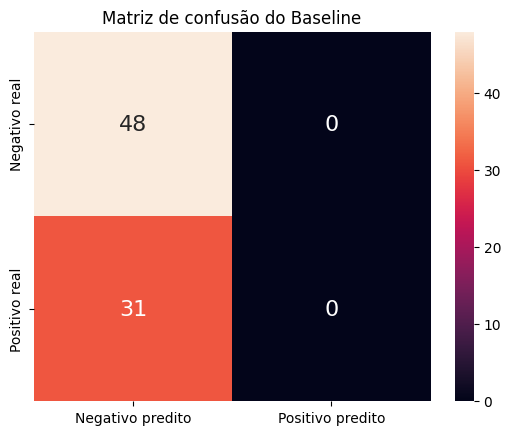

In [45]:
metricas_baseline = metricas(y_verdadeiro, y_previsao_baseline, 'o Baseline')

O Baseline, calculando a moda da variável target, previu que todos os dados assumem valor 0, isto é, nenhum terremoto acarreta em tsunami.

A matriz de confusão indica 
- VP = 0 (Verdadeiros Positivos)
- VN = 48 (Verdadeiros Negativos)
- FP = 0 (Falsos Positivos)
- FN = 31 (Falsos Negativos)

Portanto, houve 31 casos em que não alertou sobre tsunami e este aconteceu, enquanto houve 48 casos em que não alertou sobre tsunami e este de fato não ocorreu.

O valor da acurácia foi de ~ 0.607, o que indica que acertou 60.7% das previsões. Essa porcentagem é baixíssima considerando o caso de estudo em que uma previsão errada pode acarretar em muitas mortes.

A acurácia balanceada do Baseline é 0.5, pois, por natureza, prevê apenas uma das classes. Ficando ou com recall=1 e especificidade=0 ou o contrário (este caso).

Os valores do f2-score e do recall são zero, pois o baseline possui VP igual a zero. Por 'escolher' uma das classes e prever todas como sendo ela, o Baseline acaba sacrificando um dos Verdadeiros (Positivo ou Negativo).

Por outro lado, a especificidade dá o valor de 1.0, pois não há FP. Esta métrica visa compreender quantos dos negativos reais são contemplados pelo modelo (oposto do recall). Quando este comtempla todos os negativos reais, ela computa 1.0. 

O valor de precisão não é bem definido, pois resulta em uma divisão por zero. Isso se deve ao fato do Baseline não ter previsto nenhum caso como positivo.

O valor de VPN é igual ao da acurácia, pois o Baseline previu apenas valores negativos. Então a confiança do resultado negativo é justamente a distribuição dos dados.

### K-nn Classificador

--------------------------------------------------
A acurácia do kNN Classificador é 0.9241

A acurácia balanceada do kNN Classificador é 0.9147

O f2-score do kNN Classificador é 0.8824

O recall do kNN Classificador é 0.8710

A especificidade do kNN Classificador é 0.9583

A precisão do kNN Classificador é 0.9310

O VPN do kNN Classificador é 0.9200
--------------------------------------------------



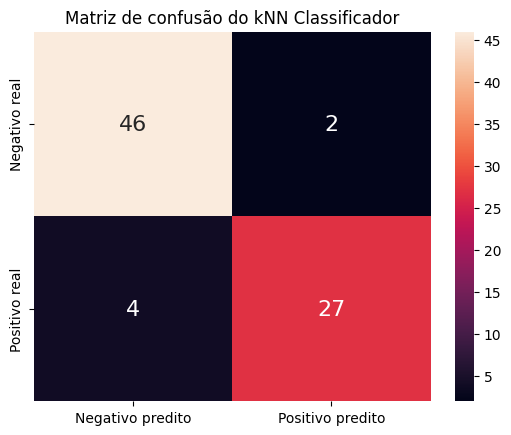

In [46]:
metricas_knn = metricas(y_verdadeiro, y_previsao_knn, 'o kNN Classificador')

A matriz de confusão do kNN indica 
- VP = 27 (Verdadeiros Positivos)
- VN = 46 (Verdadeiros Negativos)
- FP = 2 (Falsos Positivos)
- FN = 4 (Falsos Negativos)

Portanto, houve 4 casos em que não alertou sobre tsunami e este aconteceu, enquanto houve 2 casos em que alertou sobre tsunami e este não ocorreu. De imediato nota-se algo que não era esperado: o valor de FN é maior que o de FP apesar da otimização ter sido realizada pensando em penalizar FN.

O valor da acurácia foi de ~ 0.924, o que indica que acertou 92.4% das previsões. Essa porcentagem é alta, principalmente comparando aos 60.7% do Baseline. Mas errar 7.6% das previsões é bastante considerável no contexto estudado devido ao custo humano do erro.

A acurácia balanceada do kNN foi de ~ 0.915.

O valor do f2-score é de ~ 0.882, evidenciando o peso de ter 4 FN quando comparado à acurácia.

O valor do recall é de ~ 0.871, menor que o f2-score devido à maior ênfase nos FN. Este valor de recall indica que 87.1% dos casos positivos o modelo previu corretamente.

A especificidade deu ~ 0.958, valor bem alto que é resultado de apenas 2 FP. Este valor de especificidade indica que 95.8% dos casos negativos o modelo previu corretamente.

A precisão deu ~ 0.931, valor que indica 93.1% de confiança no resultado positivo.

O VPN deu 0.92, valor que indica 92.0% de confiança no resultado negativo.

Observe que o kNN em geral apresentou uma ótima performance, mas priorizou casos sem tsunami de forma que erra 12.9% (1 - recall) dos casos com tsunami. Esse valor é alto. Significa que não identifica aproximadamente 13 em cada 100 tsunamis causados por terremotos.

### Congresso de K-nn Classificadores

--------------------------------------------------
A acurácia do Congresso de K-nn Classificadores é 0.9367

A acurácia balanceada do Congresso de K-nn Classificadores é 0.9308

O f2-score do Congresso de K-nn Classificadores é 0.9091

O recall do Congresso de K-nn Classificadores é 0.9032

A especificidade do Congresso de K-nn Classificadores é 0.9583

A precisão do Congresso de K-nn Classificadores é 0.9333

O VPN do Congresso de K-nn Classificadores é 0.9388
--------------------------------------------------



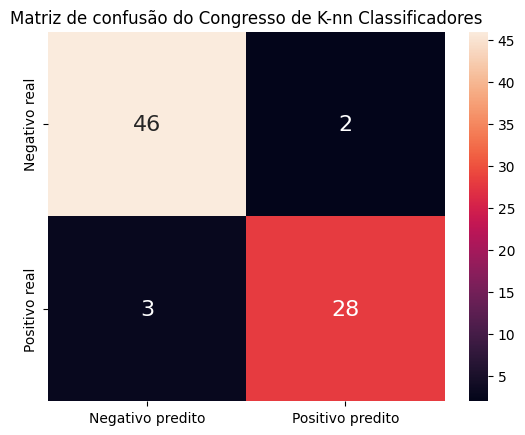

In [47]:
metricas_congresso_knn = metricas(y_verdadeiro, y_previsao_congresso_knn, 'o Congresso de K-nn Classificadores')

A matriz de confusão do congresso de kNNs indica 
- VP = 28 (Verdadeiros Positivos)
- VN = 46 (Verdadeiros Negativos)
- FP = 2 (Falsos Positivos)
- FN = 3 (Falsos Negativos)

Portanto, houve 3 casos em que não alertou sobre tsunami e este aconteceu, enquanto houve 2 casos em que alertou sobre tsunami e este não ocorreu. De imediato nota-se algo que não era esperado: o valor de FN é maior que o de FP apesar da otimização ter sido realizada pensando em penalizar FN. 

O valor da acurácia foi de ~ 0.937, o que indica que acertou 93.7% das previsões. Essa porcentagem é alta, principalmente comparando aos 60.7% do Baseline. Mas errar 6.3% das previsões é bastante considerável no contexto estudado devido ao custo humano do erro.

A acurácia balanceada foi de ~ 0.931.

O valor do f2-score é de ~ 0.909, evidenciando o peso de ter apenas 3 FN.

O valor do recall é de ~ 0.903, muito próximo do f2-score, mas menor devido aos FP serem menos do que FN. Este valor de recall indica que 90.3% dos casos positivos o modelo previu corretamente.

A especificidade deu ~ 0.958, valor bem alto que é resultado de apenas 2 FP. Este valor de especificidade indica que 95.8% dos casos negativos o modelo previu corretamente.

A precisão deu ~ 0.933, valor que indica 93.3% de confiança no resultado positivo.

O VPN deu ~ 0.939, valor que indica 93.9% de confiança no resultado negativo.

Observe que o congresso de kNN em geral apresentou uma performance muito boa, mas erra 9.7% (1 - recall) dos casos com tsunami. Esse valor é alto. Significa que não identifica aproximadamente 10 em cada 100 tsunamis causados por terremotos.

### Regressão Logística

--------------------------------------------------
A acurácia da Regressão Logística é 0.8734

A acurácia balanceada da Regressão Logística é 0.8787

O f2-score da Regressão Logística é 0.8805

O recall da Regressão Logística é 0.9032

A especificidade da Regressão Logística é 0.8542

A precisão da Regressão Logística é 0.8000

O VPN da Regressão Logística é 0.9318
--------------------------------------------------



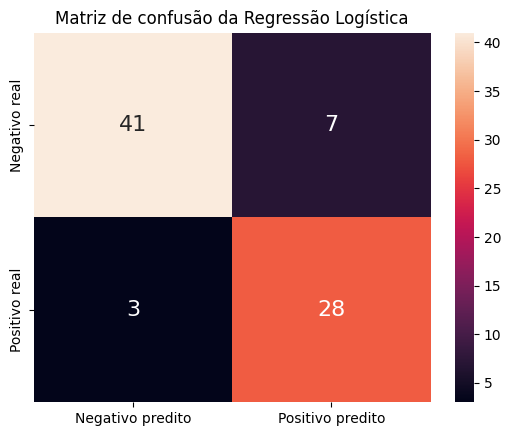

In [48]:
metricas_reglog = metricas(y_verdadeiro, y_previsao_reglog, 'a Regressão Logística')

A matriz de confusão da regressão logística indica 
- VP = 28 (Verdadeiros Positivos)
- VN = 41 (Verdadeiros Negativos)
- FP = 7 (Falsos Positivos)
- FN = 3 (Falsos Negativos)

Portanto, houve 3 casos em que não alertou sobre tsunami e este aconteceu, enquanto houve 7 casos em que alertou sobre tsunami e este não ocorreu. De imediato nota-se algo que era esperado: o valor de FN é menor que o de FP, seguindo o objetivo da otimização ter sido realizada penalizando mais FN.

O valor da acurácia foi de ~ 0.873, o que indica que acertou 87.3% das previsões. Essa porcentagem não é muito alta, mas, comparada ao Baseline, houve um aumento expressivo. Errar 12.7% das previsões é bastante considerável no contexto estudado devido ao custo humano do erro.

A acurácia balanceada do kNN foi de ~ 0.879.

O valor do f2-score é de ~ 0.881, evidenciando o a priorização dos FN, que foram poucos comparados aos FP.

O valor do recall é de ~ 0.903, maior que o f2-score devido à maior ênfase nos FN. Este valor de recall indica que 90.3% dos casos positivos o modelo previu corretamente.

A especificidade deu ~ 0.854, valor baixo comparado às outras métricas. Este valor de especificidade indica que 85.4% dos casos negativos o modelo previu corretamente.

A combinação de f2-score, recall e especificidade mostra uma forte priorização em minimizar FN em troca do valor de FP aumentar consideravelmente.

A precisão deu 0.80, valor que indica 80.0% de confiança no resultado positivo. O resultado de ter alto FP foi uma precisão baixa.

O VPN deu ~ 0.932, valor alto que indica 93.2% de confiança no resultado negativo. 

Observe que a regressão logística em geral apresentou uma performance decente. No entanto, priorizou casos com tsunami de forma que erra 9.7% (1 - recall) dos casos com tsunami. Esse valor é considerável. Significa que não identifica aproximadamente 10 em cada 100 tsunamis causados por terremotos.

### Floresta Aleatória Classificadora

--------------------------------------------------
A acurácia da Floresta Aleatória Classificadora é 0.9114

A acurácia balanceada da Floresta Aleatória Classificadora é 0.8985

O f2-score da Floresta Aleatória Classificadora é 0.8553

O recall da Floresta Aleatória Classificadora é 0.8387

A especificidade da Floresta Aleatória Classificadora é 0.9583

A precisão da Floresta Aleatória Classificadora é 0.9286

O VPN da Floresta Aleatória Classificadora é 0.9020
--------------------------------------------------



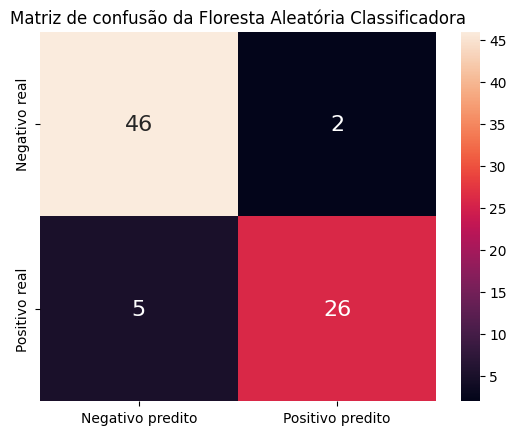

In [49]:
metricas_floresta_aleatoria = metricas(y_verdadeiro, y_previsao_tree, 'a Floresta Aleatória Classificadora')

A matriz de confusão da floresta aleatória classificadora indica 
- VP = 26 (Verdadeiros Positivos)
- VN = 46 (Verdadeiros Negativos)
- FP = 2 (Falsos Positivos)
- FN = 5 (Falsos Negativos)

Portanto, houve 5 casos em que não alertou sobre tsunami e este aconteceu, enquanto houve 2 casos em que alertou sobre tsunami e este não ocorreu. De imediato nota-se algo que não era esperado: o valor de FN é maior que o de FP apesar da otimização ter sido realizada pensando em penalizar FN.

O valor da acurácia foi de ~ 0.911, o que indica que acertou 91.1% das previsões. Essa porcentagem é alta, principalmente comparando aos 60.7% do Baseline. Mas errar 8.9% das previsões é bastante considerável no contexto estudado devido ao custo humano do erro.

A acurácia balanceada do kNN foi de ~ 0.899.

O valor do f2-score é de ~ 0.855, evidenciando o peso de ter 5 FN quando comparado à acurácia.

O valor do recall é de ~ 0.838, menor que o f2-score devido à maior ênfase nos FN. Este valor de recall indica que 83.8% dos casos positivos o modelo previu corretamente.

A especificidade deu ~ 0.958, valor bem alto que é resultado de apenas 2 FP. Este valor de especificidade indica que 95.8% dos casos negativos o modelo previu corretamente.

A precisão deu ~ 0.928, valor que indica 92.8% de confiança no resultado positivo.

O VPN deu 0.902, valor que indica 90.2% de confiança no resultado negativo.

Observe que o kNN em geral apresentou uma ótima performance, mas priorizou casos sem tsunami de forma que erra 16.2% (1 - recall) dos casos com tsunami. Esse valor é bem alto. Significa que não identifica aproximadamente 16 em cada 100 tsunamis causados por terremotos.

### SVC

--------------------------------------------------
A acurácia do SVC é 0.9241

A acurácia balanceada do SVC é 0.9204

O f2-score do SVC é 0.9032

O recall do SVC é 0.9032

A especificidade do SVC é 0.9375

A precisão do SVC é 0.9032

O VPN do SVC é 0.9375
--------------------------------------------------



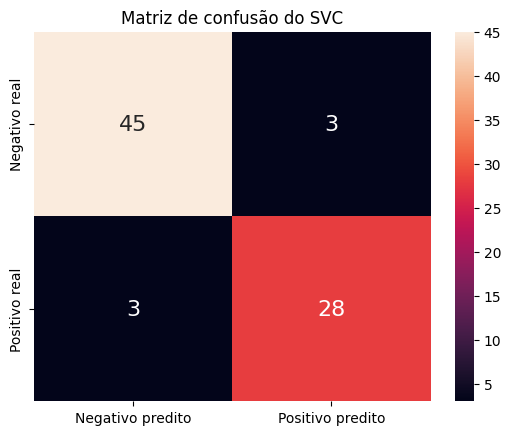

In [50]:
metricas_svc = metricas(y_verdadeiro, y_previsao_svc, 'o SVC')

A matriz de confusão do SVC indica 
- VP = 28 (Verdadeiros Positivos)
- VN = 45 (Verdadeiros Negativos)
- FP = 3 (Falsos Positivos)
- FN = 3 (Falsos Negativos)

Portanto, houve 3 casos em que não alertou sobre tsunami e este aconteceu, enquanto houve 3 casos em que alertou sobre tsunami e este não ocorreu. Nota-se um equilíbrio entre FN e FP.

O valor da acurácia foi de ~ 0.924, o que indica que acertou 92.4% das previsões. Essa porcentagem é alta, principalmente comparando aos 60.7% do Baseline. Errar 7.6% das previsões é bastante considerável no contexto estudado devido ao custo humano do erro.

A acurácia balanceada do kNN foi de ~ 0.920.

O valor do f2-score é de ~ 0.903.

O valor do recall é de ~ 0.903, iagual ao f2-score devido ao equilíbrio entre FN e FP. Este valor de recall indica que 90.3% dos casos positivos o modelo previu corretamente.

A especificidade deu ~ 0.938, valor alto comparado às outras métricas. Este valor de especificidade indica que 93.8% dos casos negativos o modelo previu corretamente.

A combinação de f2-score, recall e especificidade mostra não só o equilíbrio entre FN e FP como também a pouca quantidade deles.

A precisão deu ~ 0.903, valor que indica 90.3% de confiança no resultado positivo.

O VPN deu ~ 0.938, valor alto que indica 93.8% de confiança no resultado negativo. 

Observe que o SVC em geral apresentou uma performance muito boa, priorizando casos com tsunami de forma que erra 9.7% (1 - recall) dos casos com tsunami. Esse valor é considerável. Significa que não identifica aproximadamente 10 em cada 100 tsunamis causados por terremotos.

## Comparação de desempenho entre os modelos finais

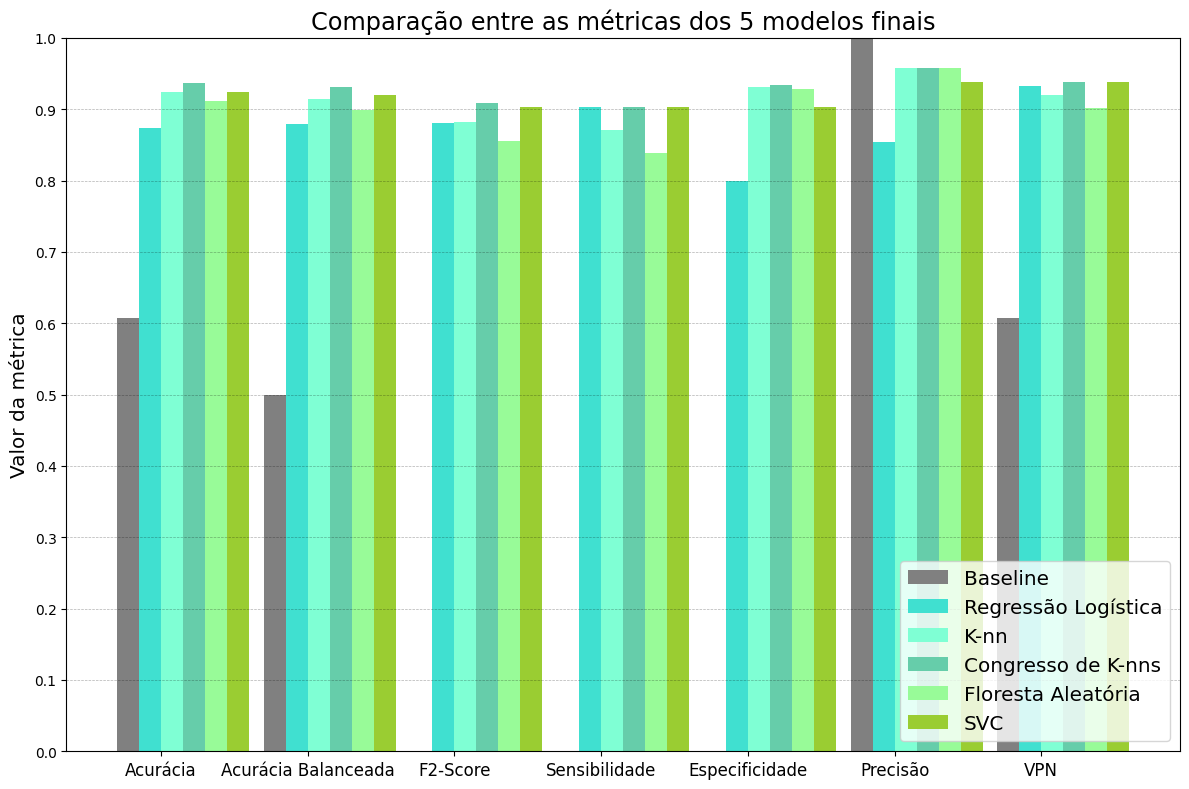

In [60]:
# Plotagem do gráfico comparativo
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=0.3)

width = 0.15 # Grossura da Barra
x_labels = ['Acurácia', 'Acurácia Balanceada', "F2-Score", "Sensibilidade", "Especificidade", "Precisão", "VPN"]
x = arange(len(metricas_baseline))

metricas_gerais = array([
    metricas_baseline,
    metricas_reglog,
    metricas_knn,
    metricas_congresso_knn,
    metricas_floresta_aleatoria, 
    metricas_svc
])

metricas_gerais = metricas_gerais.T

ax.bar(x, metricas_gerais[:, 0], width, color="grey", label="Baseline")
ax.bar(x + width, metricas_gerais[:, 1], width, color="turquoise", label="Regressão Logística")
ax.bar(x + 2 * width, metricas_gerais[:, 2], width, color="aquamarine", label="K-nn")
ax.bar(x + 3 * width, metricas_gerais[:, 3], width, color="mediumaquamarine", label="Congresso de K-nns")
ax.bar(x + 4 * width, metricas_gerais[:, 4], width, color="palegreen", label="Floresta Aleatória")
ax.bar(x + 5 * width, metricas_gerais[:, 5], width, color="yellowgreen", label="SVC")

ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(x_labels, fontsize="large")
ax.set_yticks([i / 10 for i in range(0, 12, 1)])
ax.set_ylabel("Valor da métrica", fontsize="x-large")
ax.set_ylim(0, 1)

ax.legend(loc="lower right", fontsize="x-large")
ax.set_title("Comparação entre as métricas dos 5 modelos finais", fontsize="xx-large")

fig.tight_layout()
plt.show()

O gráfico acima exprime tendências gerais dos modelos ante o conjunto de teste estratificado. Contrariando inicialmente nosso objetivo, de reduzir prioritariamente os falsos negativos, a acurácia balanceada de todos os modelos foi menor do que a acurácia simples, indicando que a quantidade proporcional de erros em geral é menor do que a de erro malquisto (FN), e logo, por complementeo, os modelos tendem a prever melhor contra o erro perdoável (FP). <br>

O F$_\beta$-score, por relacionar precisão e sensibilidade, desambigua os resultados: enquanto regressão logística, congresso de k-nns e SVC possuem sensibilidades semelhantes, de ~90%, o congresso de k-nns foi ligeiramente melhor no F$_2$-score. Enquanto isso, o K-nn, o congresso e a floresta aleatória tiveram as maiores especificidades, e praticamente iguais, de ~95%. A melhor sensibilidade somada à melhor especificidade do congresso de K-nn o tornam o modelo tanto melhor para o nosso objetivo, quanto para a qualidade de acerto geral. <br>

A precisão para a regressão logística, de ~80%, foi expressivamente menor que as para os outros modelos, mantidas em ~90%. Isso mostra a sua susceptibilidade a errar no sentido do desbalanço de dados, potencialmente por ser um modelo simplificado demais para capturar o estado minoritário, de excessão, do conjunto de dados. Enquanto isso, k-nn, congresso e floresta aleatória tiveram as maiores pontuações, de ~92%, com vantagem do congresso. Em complemento, a regressão logística, o congresso e o SVM obtiveram os melhores VPNs, ~93%, ainda com vantagem para o congresso de k-nns. <br>

Dado que o congresso de k-nns pontuou melhor em todos os testes, prosseguiremos com sua análise.

## Desempenho do Congresso K-nn

Retomemos os seus hiperparâmetros:

In [ ]:
print(params_congresso_knn)

Podemos ver que nessa otimização as métricas se distribuíram por: 6 manhattan, 4 euclidianas e 1 chebyshev, e o número de k-vizinhos foi de 71, aproximadamente 10,08% do conjunto de treino. A seleção de atributos sequencial e o PCA foram utilizados, reduzindo o número de atributos de 9 para 5 e condensando-os em 4 dimensões. <br> 

Os atributos que foram mantidos por SFS foram:

In [ ]:
pipeline_congresso_knn.named_steps['sequentialfeatureselector'].get_support()

O SFS removeu o sig, o gap, a profundidade, e a latitude. 

## Conclusões

O nosso objetivo primeiro com esse modelo é prever o melhor possível se haverá um tsunami após a detecção de um terremoto, e nesse sentido, claro, é menos danoso prever um tsunami que não ocorrerá do que prever a placidez e não evacuar as futuras vítimas do tsunami. Por essa lógica, não prezamos tanto pelo modelo de maior acurácia, mas sim que sinalize o tsunami, desde que a quantidade de erros total seja razoável - caso contrário, poderíamos evacuar todos os habitantes sempre que houvesse terremoto; não haveria porquê do modelo, ou antes, não é sequer viável.

Em todas as métricas analisadas, o congresso de kNNs classificadores foi o que teve melhor performance. Demonstrou ser o modelo que acerta mais previsões e com os valores de FN e FP mais baixos, empatado com SVC e Regressão Logística em FN, e com kNN e floresta aleatória em FP. 